## Reading Libraries 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
from nltk.tokenize import MWETokenizer
import pandas as pd

In [ ]:
nltk.download('punkt')

In [2]:
lab_data = pd.read_csv('./Training Dataset-20191010/labeled_data.csv')
unlabeled_data = pd.read_csv('./Training Dataset-20191010/unlabeled_data.csv')

In [3]:
lab_data.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


In [8]:
lab_data['text'][1].strip()

'Flirted with giving this two stars, but that\'s a pretty damning rating for what might have just been an off night...\r\n\r\nNew to the East side, and so we don\'t know many of these hidden gems, but me and the fiance met her friend for drinks here and ended up getting some things to nibble. \r\n\r\nFirst off, service was pretty slow, which was unusual because the restaurant is pretty small and galley style. You would think it would be easy for servers to routinely hit up tables as you pass by. \r\n\r\nThe fiance ordered the Quinoa Salad, and said it was pretty good, but dry. I wasn\'t too hungry and so I simply ordered the Bruchetta 3-way which came with burnt crostinis. And I ordered a side of fries, which were either hard or chewy.\r\n\r\nThe friend ordered the macaroni & cheese, and added chicken and bacon (her usual order) and liked it.  \r\n\r\nCan\'t remember the last time I thought to myself- "Huh... they failed at fries..." So, like I said- two stars. But, the decor was good,

## Case Normalisation, Tokenization and Stop words removal

In [9]:
stopwords = []
with open('./stopwords_en.txt') as f:
    stopwords = f.read().splitlines()

In [10]:
def token(raw_data):
    raw_data1 = raw_data.lower()
    tokenised = nltk.tokenize.word_tokenize(raw_data1)
    stopwords_tokens = [w for w in tokenised if not w in stopwords]
    processed_data = ' '.join(stopwords_tokens)
        
    return(processed_data)

In [11]:
lab_data['text'] = lab_data.apply(lambda row: token(row['text'].strip()), axis=1)

In [12]:
lab_data.head()

,text,label
0,"rule - waiting table ( ) , wait inside . poste...",4
1,"flirted giving stars , 's pretty damning ratin...",3
2,staying planet hollywood street good reviews p...,5
3,food good prices super expensive . 8 bucks `` ...,2
4,worse company deal horrible work bring truck b...,1


In [13]:
train = lab_data['text'].tolist()

## TFIDF + Logistic Regression

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer 


vect = TfidfVectorizer(analyzer='word', input='content', ngram_range=(1,2))
    
train_review = vect.fit_transform(train)

In [49]:
type(train_review)

scipy.sparse.csr.csr_matrix

In [38]:
# import numpy as np
# vocab = vect.get_feature_names()

# dist = np.sum(train_review.toarray(), axis=0)

# for tag, count in zip(vocab, dist):
#     print(count, tag)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_review, lab_data['label'],test_size=0.10)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=1, solver='liblinear', multi_class='ovr').fit(X_train, y_train)
pred=model.predict(X_test)

In [17]:
model.score(X_test, y_test)

0.5744

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)

Text(69.0, 0.5, 'truth')

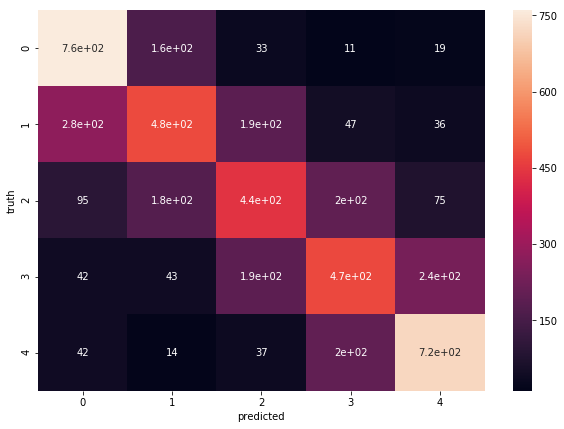

In [19]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("truth")

## Word2vec + Logistic

In [28]:
sentences = []
for review in lab_data['text']:
    sentences.append(review.split(' '))

In [32]:
len(lab_data)
?TfidfVectorizer

In [41]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2019-10-15 22:16:57,185 : INFO : 'pattern' package not found; tag filters are not available for English
2019-10-15 22:16:57,191 : INFO : collecting all words and their counts
2019-10-15 22:16:57,192 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-15 22:16:57,334 : INFO : PROGRESS: at sentence #10000, processed 662009 words, keeping 33066 word types


Training model...


2019-10-15 22:16:57,478 : INFO : PROGRESS: at sentence #20000, processed 1316478 words, keeping 47902 word types
2019-10-15 22:16:57,616 : INFO : PROGRESS: at sentence #30000, processed 1972633 words, keeping 59625 word types
2019-10-15 22:16:57,752 : INFO : PROGRESS: at sentence #40000, processed 2630117 words, keeping 69805 word types
2019-10-15 22:16:57,893 : INFO : collected 79116 word types from a corpus of 3293797 raw words and 50000 sentences
2019-10-15 22:16:57,895 : INFO : Loading a fresh vocabulary
2019-10-15 22:16:57,948 : INFO : effective_min_count=20 retains 8896 unique words (11% of original 79116, drops 70220)
2019-10-15 22:16:57,949 : INFO : effective_min_count=20 leaves 3102074 word corpus (94% of original 3293797, drops 191723)
2019-10-15 22:16:58,003 : INFO : deleting the raw counts dictionary of 79116 items
2019-10-15 22:16:58,006 : INFO : sample=0.001 downsamples 27 most-common words
2019-10-15 22:16:58,008 : INFO : downsampling leaves estimated 2375705 word corpus

In [42]:
model.doesnt_match("man woman child kitchen".split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'kitchen'

In [59]:
model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(8896, 300)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(lab_data.text, lab_data['label'],test_size=0.30)

In [64]:
def get_sentences(data):
    sentences = []
    for review in data:
        sentences.append(review.split(' '))
    return sentences

In [84]:
import numpy as np  # Make sure that numpy is imported

# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [85]:
traindataVecs = getAvgFeatureVecs(sentences, model, num_features )

Review 0 of 50000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Review 1000 of 50000
Review 2000 of 50000
Review 3000 of 50000
Review 4000 of 50000
Review 5000 of 50000
Review 6000 of 50000
Review 7000 of 50000
Review 8000 of 50000
Review 9000 of 50000
Review 10000 of 50000
Review 11000 of 50000
Review 12000 of 50000
Review 13000 of 50000
Review 14000 of 50000
Review 15000 of 50000
Review 16000 of 50000
Review 17000 of 50000
Review 18000 of 50000
Review 19000 of 50000
Review 20000 of 50000
Review 21000 of 50000
Review 22000 of 50000
Review 23000 of 50000
Review 24000 of 50000
Review 25000 of 50000
Review 26000 of 50000
Review 27000 of 50000
Review 28000 of 50000
Review 29000 of 50000
Review 30000 of 50000
Review 31000 of 50000
Review 32000 of 50000
Review 33000 of 50000
Review 34000 of 50000
Review 35000 of 50000
Review 36000 of 50000
Review 37000 of 50000
Review 38000 of 50000
Review 39000 of 50000
Review 40000 of 50000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Review 41000 of 50000
Review 42000 of 50000
Review 43000 of 50000
Review 44000 of 50000
Review 45000 of 50000
Review 46000 of 50000
Review 47000 of 50000
Review 48000 of 50000
Review 49000 of 50000


In [79]:
testdataVecs = getAvgFeatureVecs(get_sentences(X_test), model, num_features )

Review 0 of 15000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Review 1000 of 15000
Review 2000 of 15000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Review 3000 of 15000
Review 4000 of 15000
Review 5000 of 15000
Review 6000 of 15000
Review 7000 of 15000
Review 8000 of 15000
Review 9000 of 15000
Review 10000 of 15000
Review 11000 of 15000
Review 12000 of 15000
Review 13000 of 15000
Review 14000 of 15000


In [87]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(traindataVecs, lab_data['label'])

Fitting random forest to training data....


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').